# Gender by Voice

This is the interim result of my study.
The final goal is to classify the age of a person by their voice and examine, which audio features are most relevant for this task.

But today I'll show you the test study to determine the gender.
I did this task first to see:
1. If the proposed technique could be generally applied
2. Use the restult for further study: is the gender a relevant feature to determine the age of a person by their voice

# Before we start
You can peacefully ignore this for now:

In [138]:
# Imports
import os
import pandas as pd
import numpy as np
from opensmile import Smile, FeatureSet, FeatureLevel
import matplotlib.pyplot as plt
import seaborn as sns
import random
import IPython.display as ipd
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from joblib import load

In [139]:
# File paths
no_audio_csv = "/run/media/chr1s/0c135d7a-de30-4062-a5bc-16addf703a18/uni/SAudio/csv_saves/no_audio/save_voices_440000.csv"
gemaps_features_csv = "/run/media/chr1s/0c135d7a-de30-4062-a5bc-16addf703a18/uni/SAudio/csv_saves/gemaps/features.csv"
gemaps_voices_csv = "/run/media/chr1s/0c135d7a-de30-4062-a5bc-16addf703a18/uni/SAudio/csv_saves/gemaps/voices.csv"

random_forest = "/run/media/chr1s/0c135d7a-de30-4062-a5bc-16addf703a18/uni/SAudio/models/randomforest/random_forest_model.joblib"

audio_path = "/run/media/chr1s/0c135d7a-de30-4062-a5bc-16addf703a18/uni/SAudio/datasets/CV/en/clips/"

## The Dataset

I used the [Mozilla Common Voice (CV)](https://commonvoice.mozilla.org/de) Dataset.
This is a dataset consisting of almost 20k voices, and more than 1k validated hours of speech.
Each audio file is a small single spoken sentence of one speaker. Each audio file has associated labels, including voice_id, accent, age_group, etc.

### The Data I used

I did not have the chance to use the whole dataset. Firstly because my computer simply cound't handle it and secondly because not every audio file is completely labeled. Another reason to trim the dataset is to create a more balanced distribution of labels: the gender ratio is rouchly 60% Male 8% Female (the rest is unlabeled, **additional genders were not labeled**).

I created a simple parser class to parse the tsv information first into a pandas DataFrame object and then back into a csv. I ignored all data points with the required labels age_group and gender missing.

The resulting DataFrame looks like this: 

In [140]:
df = pd.read_csv(no_audio_csv, index_col="clip_id")
df.head()

,audio_file_name,voice_name,voice_age,voice_age_group,voice_gender,features_extracted
clip_id,,,,,,
51946c6f-7448-4742-b61c-17e583981911,common_voice_en_18188256.mp3,50_m_00347,NaN,50,m,False
75dfdd53-b728-4e38-bd92-9da282627f1d,common_voice_en_17804843.mp3,70_m_008fe,NaN,70,m,False
9deb7f24-3404-4dac-be07-e7ff539f10a2,common_voice_en_17534895.mp3,20_m_01750,NaN,20,m,False
7d62e834-e358-4f13-9087-399096eab450,common_voice_en_38389114.mp3,20_m_017fb,NaN,20,m,False
f249640e-9fd8-4a3e-abf7-c82272338b15,common_voice_en_34382925.mp3,20_m_02383,NaN,20,m,False


In [141]:
random_row = df.loc[random.choice(df.index)]
random_row

audio_file_name       common_voice_en_25959034.mp3
voice_name                              20_m_41f64
voice_age                                      NaN
voice_age_group                                 20
voice_gender                                     m
features_extracted                           False
Name: 3266e2bf-f065-45a4-9eb7-dda926d198bd, dtype: object

### Problem:

As I said earlier, the distribution of the gender is off:

In [142]:
df.voice_gender.value_counts()

voice_gender
m    337032
f    102968
Name: count, dtype: int64

I solved this by undersampling the male voice audio files. So each gender should have an equal amount of data.
A random selection of male voice audio files will be discarded. 

In [143]:
del df

## Where are the audio features?

Right now we only have the labels and the path to an audio file:

In [144]:
audio_file = os.path.join(audio_path, random_row.audio_file_name)
ipd.Audio(audio_file) 

## Smile + GeMAPS

I implemented a feature extraction method in the parser from earlier.
The parser can handle three kinds of feature sets: ComParE2016 (6373 Features), eGeMAPSv2 (88 Features) and a custom one (currently at 36 Features)

For the study I tired all feature sets. While a scientific comparison did not happen yet, I have made the best results with the eGeMAPSv2 feature set.

How this feature set actually works and what each feature means can be explored in the Notebook: explore_gemaps (work in progress).

In [145]:
# Load the feature extractor
smile = Smile(
    feature_set=FeatureSet.eGeMAPSv02,
    feature_level=FeatureLevel.Functionals,
)
smile.feature_names[:10]

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope']

In [146]:
# Extract features from the random audio file:
smile_features = smile.process_file(audio_file).iloc[0]
smile_features

F0semitoneFrom27.5Hz_sma3nz_amean             26.715689
F0semitoneFrom27.5Hz_sma3nz_stddevNorm         0.171282
F0semitoneFrom27.5Hz_sma3nz_percentile20.0    25.203964
F0semitoneFrom27.5Hz_sma3nz_percentile50.0    26.222847
F0semitoneFrom27.5Hz_sma3nz_percentile80.0    27.353197
                                                ...    
MeanVoicedSegmentLengthSec                     0.222000
StddevVoicedSegmentLengthSec                   0.266713
MeanUnvoicedSegmentLength                      0.182727
StddevUnvoicedSegmentLength                    0.219342
equivalentSoundLevel_dBp                     -24.868923
Name: (/run/media/chr1s/0c135d7a-de30-4062-a5bc-16addf703a18/uni/SAudio/datasets/CV/en/clips/common_voice_en_25959034.mp3, 0 days 00:00:00, 0 days 00:00:04.500000), Length: 88, dtype: float32

## Do this for the whole dataset (and wait.... a long time...)

After doing this for every audio file we have a second csv:


- One csv contains the features of the voice, including the labels of the dataset.
- The other csv contains the audio features of each audio file.

In [147]:
voices = pd.read_csv(gemaps_voices_csv, index_col="clip_id")
features = pd.read_csv(gemaps_features_csv, index_col="clip_id")
voices.head()

,audio_file_name,voice_name,voice_age,voice_age_group,voice_gender,features_extracted
clip_id,,,,,,
3d060d83-adbd-44e0-afce-b826aa5381b1,common_voice_en_19666343.mp3,20_m_0b062,NaN,20,m,True
ecd475b2-3015-4ce5-a2fe-81534bf945b0,common_voice_en_23711401.mp3,30_m_89b1e,NaN,30,m,True
01374f0c-ff48-4663-a42d-08c4f184e299,common_voice_en_27285325.mp3,30_m_b229e,NaN,30,m,True
4c985ac7-9e16-4dc9-9c45-2127a16fe7fe,common_voice_en_216280.mp3,20_m_6603d,NaN,20,m,True
e878a03f-b309-4197-8e87-40b42e5c431d,common_voice_en_35888106.mp3,30_m_bdd6a,NaN,30,m,True


In [148]:
features.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
clip_id,,,,,,,,,,,,,,,,,,,,,
3d060d83-adbd-44e0-afce-b826aa5381b1,22.179844,0.339790,18.409922,20.131195,23.650680,5.240759,266.153960,232.235800,103.508570,71.248960,...,0.031013,0.002345,0.413786,4.216867,2.231237,0.266364,0.171213,0.193333,0.241707,-21.007450
ecd475b2-3015-4ce5-a2fe-81534bf945b0,24.322006,0.580217,16.880875,18.579967,21.307907,4.427032,398.797424,396.038849,428.149078,629.003845,...,0.017557,-0.001341,0.670560,4.521739,4.035088,0.130870,0.100733,0.133750,0.138829,-22.155727
01374f0c-ff48-4663-a42d-08c4f184e299,24.174156,0.338320,19.873123,21.779720,25.701950,5.828827,657.793335,725.710876,132.189041,112.811546,...,0.035306,-0.002314,0.359165,3.954802,3.612167,0.151053,0.126195,0.110000,0.161417,-21.083681
4c985ac7-9e16-4dc9-9c45-2127a16fe7fe,24.890310,0.161558,22.497490,26.137222,27.981504,5.484015,115.091469,60.737309,107.501930,79.021454,...,0.075598,0.002145,0.150634,2.822581,1.239670,0.556667,0.332499,0.170000,0.123491,-18.839119
e878a03f-b309-4197-8e87-40b42e5c431d,30.156759,0.309775,23.325962,32.324020,34.654331,11.328369,81.758034,38.350334,310.445709,94.248108,...,0.064182,0.021776,0.155598,2.553192,2.178649,0.129000,0.117000,0.308000,0.364357,-28.008059


In [149]:
voices.voice_gender.value_counts()

voice_gender
m    102968
f    102968
Name: count, dtype: int64

# Time for AI Magic!

Now that there are features and labels we can use the power of AI!

The main goal for this intermediate project is to find relevant audio features from a voice, that can determine the gender of a person.

To achive this, we first need a machine, that can use a set of given audio features to determine the gender of a person.

If this step works, we know, that some of the features may actually hold some informations that can reveal the gender of a person.

Later we'll use this machine to determine, what features that may be...

## Binary Classification

Eventhough we have the list of voices and features, we cannot directly train an AI model.

We need to create a task, that a machine is able to understand.

In our case with the gender classification the task is the following:
*"With the given set of 88 float value features, predict the possiblity of the voice being either male or female."*

To make this task easier we first reduce the two gender classes into a single one: male (1) or female (0)

Then we organize the data according to standard data science procedure:



In [150]:
data = pd.merge(voices[["voice_gender"]], features, on="clip_id")

In [151]:
data["voice_gender_m"] = data["voice_gender"].apply(lambda x: 1 if x == "m" else 0)
data.drop(columns="voice_gender", inplace=True)

In [152]:
X = data.drop(columns="voice_gender_m")
y = data["voice_gender_m"]

In [153]:
X.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
clip_id,,,,,,,,,,,,,,,,,,,,,
3d060d83-adbd-44e0-afce-b826aa5381b1,22.179844,0.339790,18.409922,20.131195,23.650680,5.240759,266.153960,232.235800,103.508570,71.248960,...,0.031013,0.002345,0.413786,4.216867,2.231237,0.266364,0.171213,0.193333,0.241707,-21.007450
ecd475b2-3015-4ce5-a2fe-81534bf945b0,24.322006,0.580217,16.880875,18.579967,21.307907,4.427032,398.797424,396.038849,428.149078,629.003845,...,0.017557,-0.001341,0.670560,4.521739,4.035088,0.130870,0.100733,0.133750,0.138829,-22.155727
01374f0c-ff48-4663-a42d-08c4f184e299,24.174156,0.338320,19.873123,21.779720,25.701950,5.828827,657.793335,725.710876,132.189041,112.811546,...,0.035306,-0.002314,0.359165,3.954802,3.612167,0.151053,0.126195,0.110000,0.161417,-21.083681
4c985ac7-9e16-4dc9-9c45-2127a16fe7fe,24.890310,0.161558,22.497490,26.137222,27.981504,5.484015,115.091469,60.737309,107.501930,79.021454,...,0.075598,0.002145,0.150634,2.822581,1.239670,0.556667,0.332499,0.170000,0.123491,-18.839119
e878a03f-b309-4197-8e87-40b42e5c431d,30.156759,0.309775,23.325962,32.324020,34.654331,11.328369,81.758034,38.350334,310.445709,94.248108,...,0.064182,0.021776,0.155598,2.553192,2.178649,0.129000,0.117000,0.308000,0.364357,-28.008059


In [154]:
y.value_counts()

voice_gender_m
1    102968
0    102968
Name: count, dtype: int64

In [155]:
# split the data into training and testing sets
# Eventhough we wont train the model in here, the test set will be used to evaluate the model live
# Ignore, that the model may have seen some of the data :)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [156]:
del X_train, y_train

## Trees

The AI Model I used for this binary classification problem (male yes-no) is a Random Forest.
Trees are still very relevant AI models, especially for tabular style input data.
I first tried a simple DecisionTree model, but the performance was not optimal, a big RandomForest worked better

The parameter for this model were not searched properly (the grid search would take too long on my pc >w<)

The current model uses **500 Trees** and a **maximum depth of 5**.



In [157]:
model = load(random_forest)

## Predictions

Now we can make predictions with the trained model:

In [158]:
# Binary predictions
y_pred = model.predict(X_test)
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [159]:
# Probability predictions
y_pred_proba = model.predict_proba(X_test)
y_pred_proba

array([[0.05095483, 0.94904517],
       [0.07313698, 0.92686302],
       [0.94898912, 0.05101088],
       ...,
       [0.08563413, 0.91436587],
       [0.92489787, 0.07510213],
       [0.92251569, 0.07748431]])

## Model Evaluation

Lets test how well this model performs, before we go on with the feature importance:

In [160]:
# The % of right guesses
accuracy_score(y_test, y_pred)

0.920583665145188

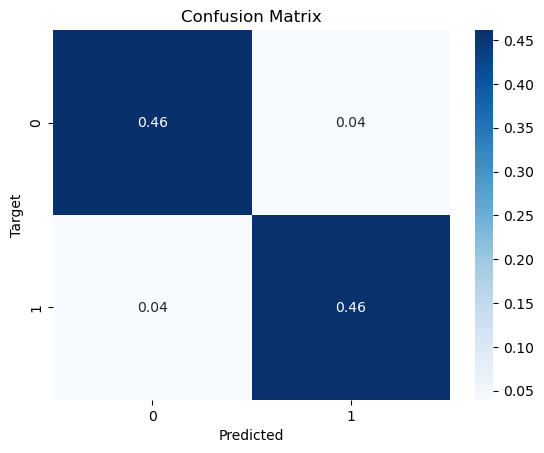

In [161]:
sns.heatmap((confusion_matrix(y_test, y_pred)/y_pred.shape[0]), annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.title("Confusion Matrix")
plt.show()

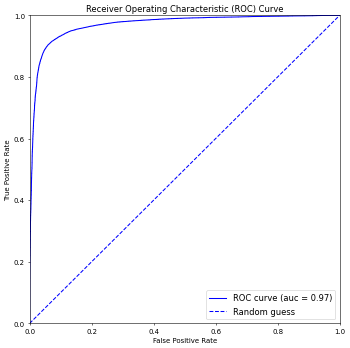

In [162]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8, 8), dpi=50)
ax.plot(fpr, tpr, label="ROC curve (auc = {:.2f})".format(roc_auc), color="blue")
ax.plot([0, 1], [0, 1], linestyle="--", color="blue", label="Random guess")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic (ROC) Curve")
ax.legend(loc="lower right", fontsize=12)
plt.show()

In [163]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.9698396483888486

# Model Done, Main Task ahead:

Now that we have a machine that can roughly determine the gender of a person by the audio features of their voice, we can identify, which features have the most influence in the decision process.

The magic lies with SHAP (for trees).
SHAP is a local model explanation tool that can later lead to global understanding.

## Local Explanations

Lets see how the model thinks for a random voice:

In [165]:
random_voice_id = random.choice(X_test.index)
random_voice_X = X_test.loc[random_voice_id]
random_voice_y = y_test.loc[random_voice_id]
random_voice_y_detailed = voices.loc[random_voice_id]
random_voice_y_detailed

audio_file_name       common_voice_en_19005728.mp3
voice_name                              20_m_391f1
voice_age                                      NaN
voice_age_group                                 20
voice_gender                                     m
features_extracted                            True
Name: 3750990c-bf3d-409c-8c9c-d7af794954ae, dtype: object

In [181]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(random_voice_X)
pd.DataFrame(shap_values[:, 1].reshape(1, -1), columns=X_test.columns).T.sort_values(0, ascending=False).head(10)

,0
F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.108645
F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.060039
F0semitoneFrom27.5Hz_sma3nz_amean,0.057539
F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.054529
F3frequency_sma3nz_amean,0.030098
slopeV0-500_sma3nz_amean,0.018203
F2frequency_sma3nz_amean,0.016652
F1frequency_sma3nz_stddevNorm,0.016481
mfcc4V_sma3nz_stddevNorm,0.011752
mfcc4V_sma3nz_amean,0.011064


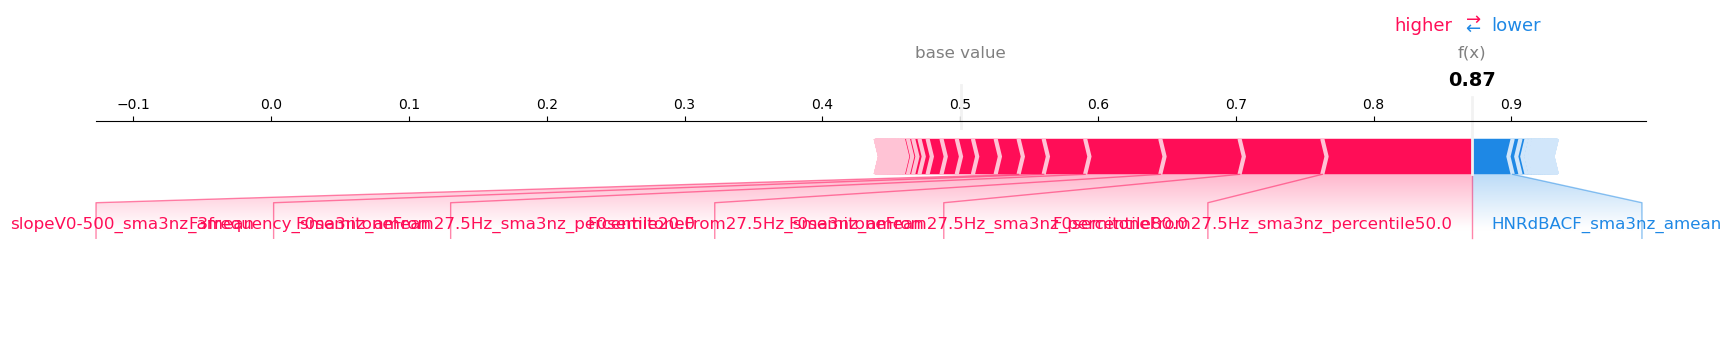

In [169]:
shap.force_plot(explainer.expected_value[1], shap_values[:, 1], feature_names=X_test.columns, matplotlib=True)

## Global Explanations

By combining many (many) of these kinds of local explanations we get a better understanding of how the model works overall.

In [184]:
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test[:1000], check_additivity=False)

 97%|=================== | 1943/2000 [00:30<00:00]       

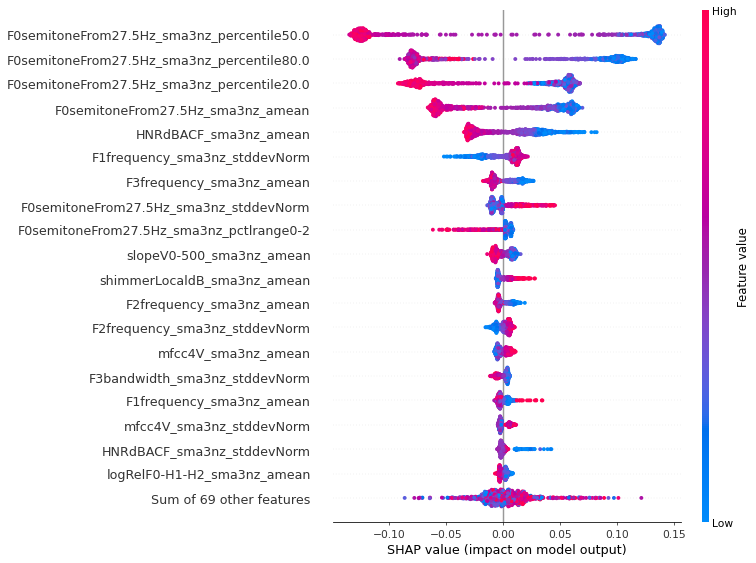

In [187]:
plt.figure(dpi=70)
shap.plots.beeswarm(shap_values[:, :, 1], max_display=20)

# Results

Now lets examine the results:

## Most important Feature(s) F0 -> the base pitch

The first four features all have the same audio feature in common: They are statistical descriptors of the main pitch.
The SHAP diagram shows, that a low average pitch has a high shap value (towards male) and vice versa.

This is a basic property we all may have intuitively guessed, but the SHAP analysis shows, that even a machine takes the main pitch of a voice as one of the most importand indicators of the gender of a person.

## HNR in top 5:

This was quite to my surprise. It seems like the model also takes the mean Harmonics to Noise Ratio (HNR) into consideration.

A low HNR value means, that there is more noise in the audio data (non-harmonic audio content), while a high HNR value means that the audio is sharper with less noise.

The SHAP analysis shows, that voices with a high HNR are more associated with female voices, while predicted male voices seem to have a lower HNR.


My first guess would be that the overall roughness though factors like breathiness, vocal fry, or irregular glottal pulses decreases the HNR for males.

## F1 reversed?

While all pitches follow the same pattern for the model: high => female, low => male, F1 falls out of this pattern.

The stddev F1 on the 6th place of SHAP contribution values shows the interesting trend of low => female, high => male.

Its important to note, that stddev does not mean pitch in this case (that would be amean, or any percentile).
Instead stddev means the gaussian distribution of the F1 Pitch over its mean value.

According to the SHAP plot, this means that female voices tend to keep the same pitch for the second harmonic F1. Male voices on the other hand seem to change their second harmonic pitch more often.

My guess would be again, that this is because of the rougher nature of the male voice.